In [3]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline

from preprocess_sunshine import sunshine_transformer
from preprocess_raintomorrow import raintomorrow_transformer
from preprocess_date import preprocess_date_transformer
from preprocess_temp import preprocess_temp
from preprocess_rainfall_raintoday import rainfall_raintoday_transformer
from preprocess_wind import wind_speed_transformer, wind_dir_transformer
from preprocess_humidity_pressure import VoisinageNAImputer
from preprocess_evaporation import evaporation_transformer
from preprocess_cloud import cloud_transformer



from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import IsotonicRegression

from sklearn.linear_model import LogisticRegression

from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, brier_score_loss, roc_curve, roc_auc_score, precision_recall_curve, recall_score, precision_score, log_loss


In [22]:
df = pd.read_csv('../data/weatherAUS.csv')

city = 'CoffsHarbour'

df = df[df['Location'].isin([city])]

df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [23]:

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/weatherAUS.csv')

city = 'CoffsHarbour'

df = df[df['Location'].isin([city])]

# print(df.columns)
# print(df.isna().sum()/len(df)*100)
print(df.dtypes)
# print(df.isna().sum()/len(df))

columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

print('colonne drop', columns_to_drop)
print('colonne du dataframe', df.columns)

transformers = []

if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))

if 'Evaporation' not in columns_to_drop:
    transformers.append(('evaporation_transformer', evaporation_transformer()))
if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))

if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

for cloud_col in ['Cloud9am', 'Cloud3pm']:
    if cloud_col not in columns_to_drop:
        transformers.append((f'{cloud_col.lower()}_transformer', cloud_transformer(col_select=cloud_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')

print('avant', df.shape)
df.dropna(inplace = True)
print('apres', df.shape)

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object
colonne drop ['Evaporation', 'Sunshine']
colonne du dataframe Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
     

In [24]:
pd.set_option('display.max_rows', None)
df.isna().sum()

MinTemp                 0
MaxTemp                 0
Rainfall                0
WindGustSpeed           0
WindSpeed9am            0
WindSpeed3pm            0
Humidity9am             0
Humidity3pm             0
Pressure9am             0
Pressure3pm             0
Cloud9am                0
Cloud3pm                0
Temp9am                 0
Temp3pm                 0
RainToday               0
RainTomorrow            0
year                    0
sin_months              0
cos_months              0
MinTemp_mean_7          0
MinTemp_std_7           0
MinTemp_max_7           0
MinTemp_min_7           0
MinTemp_mean_5          0
MinTemp_std_5           0
MinTemp_max_5           0
MinTemp_min_5           0
MinTemp_mean_3          0
MinTemp_std_3           0
MinTemp_max_3           0
MinTemp_min_3           0
MinTemp_diff            0
MaxTemp_mean_7          0
MaxTemp_std_7           0
MaxTemp_max_7           0
MaxTemp_min_7           0
MaxTemp_mean_5          0
MaxTemp_std_5           0
MaxTemp_max_

In [25]:
X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poids = y_train.value_counts(normalize = True)
print(poids)

model = LogisticRegression(verbose = 1,
                           C = 1,
                           max_iter = 1000,
                           penalty = 'l1',
                           solver = 'liblinear',
                           intercept_scaling = 0.1,
                           tol = 0.01
                        )


model.fit(X_train_scaled, y_train)


prob = model.predict_proba(X_test_scaled)

y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

if y_train.value_counts(normalize = True)[1] < 0.15:
        threshold = 0.165
if y_train.value_counts(normalize = True)[1] > 0.30:
    threshold = 0.85
else:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
    diff = abs(precision - recall)
    threshold = thresholds[diff.argmin()]

print('threshold :', threshold)

y_pred = (y_pred_prob1 > threshold).astype(int)


print('Accuracy score: ', model.score(X_test_scaled, y_test))
print('F1 score: ', f1_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))
print('Brier score: ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
classif = classification_report(y_test, y_pred)
print(classif)

RainTomorrow
0.0    0.666667
1.0    0.333333
Name: proportion, dtype: float64
[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 4
iter   5  #CD cycles 1
iter   6  #CD cycles 12
optimization finished, #iter = 6
Objective value = 585.302069
#nonzeros/#features = 68/116
threshold : 0.85
Accuracy score:  0.7917485265225933
F1 score:  0.33175355450236965
ROC AUC score:  0.5932561782109292
Brier score:  0.2770137524557957 


[[333   7]
 [134  35]] 


              precision    recall  f1-score   support

         0.0       0.71      0.98      0.83       340
         1.0       0.83      0.21      0.33       169

    accuracy                           0.72       509
   macro avg       0.77      0.59      0.58       509
weighted avg       0.75      0.72      0.66       509



In [ ]:
print(X_train.isna().sum())

In [ ]:
# y_pred_prob = model.predict_proba(X_test_scaled)
# probs_inverted = 1 - probs_scaled
# probs_normalized_1 = probs_inverted / np.max(probs_inverted)


plt.figure(figsize = (20, 10))
plt.subplot(121)
sns.histplot(prob, bins = 50, kde = True,
             stat = 'count', multiple = 'dodge',
             color = ['yellow', 'blue'])
plt.xlabel('Probability')
plt.legend(title='Class', labels=['Class 1 - RainTomorrow', 'Class 0 - No RainTomorrow'], loc='upper center')
plt.title(f'Probabilité des classes pour {city}')

plt.subplot(122)
sns.boxplot(prob)
plt.xlabel('Probability')
plt.title(f'Probabilité des classes pour {city}')
plt.show()
plt.show()


In [ ]:
f1_1 = []
roc_1 = []
precision1 = []
recall1 = []
accuracy = []

for i in np.linspace(0, 1, 1000):

    seuil = i

    y_pred = (y_pred_prob1 > i).astype("int32")
    accuracy.append(accuracy_score(y_test, y_pred))
    f1_1.append(f1_score(y_test, y_pred))
    roc_1.append(roc_auc_score(y_test, y_pred))
    precision1.append(precision_score(y_test, y_pred))
    recall1.append(recall_score(y_test, y_pred))

plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(accuracy, label = 'accuracy')
plt.plot(f1_1, label = 'f1')
plt.plot(roc_1, label = 'roc-auc')
plt.plot(precision1, label = 'precision')
plt.plot(recall1, label = 'recall')
plt.title(f'Evolution des metriques en fonction du seuil pour {city}')
plt.legend()

plt.show()

In [ ]:
df = pd.read_csv('../data/weatherAUS.csv')


print(df['Location'].unique())

{'0.0': {'precision': 0.9057851239669421, 'recall': 0.9072847682119205, 'f1-score': 0.9065343258891646, 'support': 604.0}, '1.0': {'precision': 0.68, 'recall': 0.6761363636363636, 'f1-score': 0.6780626780626781, 'support': 176.0}, 'accuracy': 0.8551282051282051, 'macro avg': {'precision': 0.792892561983471, 'recall': 0.7917105659241421, 'f1-score': 0.7922985019759213, 'support': 780.0}, 'weighted avg': {'precision': 0.8548387370205552, 'recall': 0.8551282051282051, 'f1-score': 0.8549817489437009, 'support': 780.0}}


In [26]:

df_1 = pd.read_csv('../data/weatherAUS.csv')

list_city = []
list_accuracy = []
list_f1 = []
list_recall = []
list_precision = []
list_roc = []

precision_0 = []
recall_0 = []
f1_0 = []
support_0 = []
precision_1 = []
recall_1 = []
f1_1 = []
support_1 = []

macro_avg_precision = []
macro_avg_recall = []
macro_avg_f1 = []

weighted_avg_precision = []
weighted_avg_recall = []
weighted_avg_f1 = []





# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = df_1['Location'].unique()
print(city)
for i in city:
    print('la ville -----------------', i)

    df = df_1[df_1['Location'].isin([i])]

    columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

    # print('colonne drop', columns_to_drop)
    # print('colonne du dataframe', df.columns)

    transformers = []
    if 'RainTomorrow' not in columns_to_drop:
        transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
    if 'Evaporation' not in columns_to_drop:
        transformers.append(('evaporation_transformer', evaporation_transformer()))
    if 'Sunshine' not in columns_to_drop:
        transformers.append(('sunshine_transformer', sunshine_transformer()))
    if 'Date' not in columns_to_drop:
        transformers.append(('date_transformer', preprocess_date_transformer()))
    for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
        if temp_col not in columns_to_drop:
            transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
    for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
        if wind_col not in columns_to_drop:
            transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
    for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        if wind_dir_col not in columns_to_drop:
            transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
    if 'Rainfall' not in columns_to_drop:
        transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
    for humidity_col in ['Humidity9am', 'Humidity3pm']:
        if humidity_col not in columns_to_drop:
            transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
    for pressure_col in ['Pressure9am', 'Pressure3pm']:
        if pressure_col not in columns_to_drop:
            transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))
    for cloud_col in ['Cloud9am', 'Cloud3pm']:
        if cloud_col not in columns_to_drop:
            transformers.append((f'{cloud_col.lower()}_transformer', cloud_transformer(col_select=cloud_col)))



    df_transformed = Pipeline(transformers).fit_transform(df)

    df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
    df = df.set_index('Date')
    print(df.columns)

    df.dropna(inplace = True)


    X = df.drop(columns = 'RainTomorrow')
    y = df['RainTomorrow']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    scaler = MinMaxScaler(feature_range = (-1, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    model = LogisticRegression(verbose = 1, C = 1, max_iter = 10000, penalty = 'l1',
                               solver = 'liblinear',
                               intercept_scaling = 0.1, l1_ratio = 0.5, tol = 0.01,)


    model.fit(X_train_scaled, y_train)

    print(y_train.value_counts(normalize = True))
    print(y_train.value_counts())

    prob = model.predict_proba(X_test_scaled)

    y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

    if y_train.value_counts(normalize = True)[1] < 0.15:
            threshold = 0.165
    if y_train.value_counts(normalize = True)[1] > 0.30:
        threshold = 0.85
    else:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
        diff = abs(precision - recall)
        threshold = thresholds[diff.argmin()]


    y_pred = (y_pred_prob1 > threshold).astype(int)

    list_city.append(i)

    list_accuracy.append(model.score(X_test_scaled, y_test))
    list_f1.append(f1_score(y_test, y_pred))
    list_roc.append(roc_auc_score(y_test, y_pred))
    list_precision.append(precision_score(y_test, y_pred))
    list_recall.append(recall_score(y_test, y_pred))

    classif = classification_report(y_test, y_pred, output_dict = True)

    precision_0.append(classif['0.0']['precision'])
    recall_0.append(classif['0.0']['recall'])
    f1_0.append(classif['0.0']['f1-score'])
    support_0.append(classif['0.0']['support'])

    precision_1.append(classif['1.0']['precision'])
    recall_1.append(classif['1.0']['recall'])
    f1_1.append(classif['1.0']['f1-score'])
    support_1.append(classif['1.0']['support'])

    macro_avg_precision.append(classif['macro avg']['precision'])
    macro_avg_recall.append(classif['macro avg']['recall'])
    macro_avg_f1.append(classif['macro avg']['f1-score'])

    weighted_avg_precision.append(classif['weighted avg']['precision'])
    weighted_avg_recall.append(classif['weighted avg']['recall'])
    weighted_avg_f1.append(classif['weighted avg']['f1-score'])


['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
la ville ----------------- Albury
Pas de station à moins de 50 km de Albury
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm',
       ...
       'WindSpeed3pm_std_3', 'WindSpeed3pm_max_3', 'WindSpeed3pm_min_3',
       'WindSpeed3pm_diff', 'WindGustDir_cos', 'WindGustDir_sin',
       'WindDir9am_cos', 'Win

{'0.0': {'precision': 0.9057851239669421, 'recall': 0.9072847682119205, 'f1-score': 0.9065343258891646, 'support': 604.0}, '1.0': {'precision': 0.68, 'recall': 0.6761363636363636, 'f1-score': 0.6780626780626781, 'support': 176.0}, 'accuracy': 0.8551282051282051, 'macro avg': {'precision': 0.792892561983471, 'recall': 0.7917105659241421, 'f1-score': 0.7922985019759213, 'support': 780.0}, 'weighted avg': {'precision': 0.8548387370205552, 'recall': 0.8551282051282051, 'f1-score': 0.8549817489437009, 'support': 780.0}}

In [27]:
df_global = pd.DataFrame({
    'location' : list_city,
    'accuracy' : list_accuracy,
    'f1': list_f1,
    'roc-auc' : list_roc,
    'precision' : list_precision,
    'recall' : list_recall,
    'precision_0' : precision_0,
    'recall_0' : recall_0,
    'f1_0' : f1_0,
    'support_0' : support_0,
    'precision_1' : precision_1,
    'recall_1' : recall_1,
    'f1_1' : f1_1,
    'support_1' : support_1,
    'macro_avg_precision' : macro_avg_precision,
    'macro_avg_recall' : macro_avg_recall,
    'macro_avg_f1' : macro_avg_f1,
    'weighted_avg_precision' : weighted_avg_precision,
    'weighted_avg_recall' : weighted_avg_recall,
    'weighted_avg_f1' : weighted_avg_f1
    }
)

df_global.set_index('location', inplace = True)


df_global.to_csv('../data_saved/first_result_evap.csv')

In [28]:
df_global.mean(axis = 0)

accuracy                    0.857782
f1                          0.613735
roc-auc                     0.755019
precision                   0.695383
recall                      0.587080
precision_0                 0.880349
recall_0                    0.922959
f1_0                        0.898650
support_0                 407.673469
precision_1                 0.695383
recall_1                    0.587080
f1_1                        0.613735
support_1                 119.306122
macro_avg_precision         0.787866
macro_avg_recall            0.755019
macro_avg_f1                0.756193
weighted_avg_precision      0.847819
weighted_avg_recall         0.841791
weighted_avg_f1             0.833807
dtype: float64

In [29]:
df_global

,accuracy,f1,roc-auc,precision,recall,precision_0,recall_0,f1_0,support_0,precision_1,recall_1,f1_1,support_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1
location,,,,,,,,,,,,,,,,,,,
Albury,0.859296,0.633745,0.769258,0.636364,0.631148,0.905462,0.907368,0.906414,475.0,0.636364,0.631148,0.633745,122.0,0.770913,0.769258,0.770080,0.850471,0.850921,0.850693
BadgerysCreek,0.873162,0.610329,0.756828,0.613208,0.607477,0.904110,0.906178,0.905143,437.0,0.613208,0.607477,0.610329,107.0,0.758659,0.756828,0.757736,0.846892,0.847426,0.847156
Cobar,0.913828,0.642336,0.790934,0.647059,0.637681,0.941995,0.944186,0.943089,430.0,0.647059,0.637681,0.642336,69.0,0.794527,0.790934,0.792713,0.901213,0.901804,0.901502
CoffsHarbour,0.793612,0.289157,0.577165,0.800000,0.176471,0.702918,0.977860,0.817901,271.0,0.800000,0.176471,0.289157,136.0,0.751459,0.577165,0.553529,0.735358,0.710074,0.641220
Moree,0.914847,0.721805,0.835191,0.727273,0.716418,0.951531,0.953964,0.952746,391.0,0.727273,0.716418,0.721805,67.0,0.839402,0.835191,0.837275,0.918724,0.919214,0.918962
Newcastle,0.802893,0.560886,0.708668,0.562963,0.558824,0.856459,0.858513,0.857485,417.0,0.562963,0.558824,0.560886,136.0,0.709711,0.708668,0.709185,0.784279,0.784810,0.784542
NorahHead,0.789565,0.643533,0.753447,0.645570,0.641509,0.863309,0.865385,0.864346,416.0,0.645570,0.641509,0.643533,159.0,0.754439,0.753447,0.753939,0.803100,0.803478,0.803286
NorfolkIsland,0.826011,0.355556,0.603408,0.851064,0.224719,0.735632,0.982097,0.841183,391.0,0.851064,0.224719,0.355556,178.0,0.793348,0.603408,0.598369,0.771743,0.745167,0.689264
Penrith,0.892794,0.669604,0.792674,0.672566,0.666667,0.916667,0.918681,0.917673,455.0,0.672566,0.666667,0.669604,114.0,0.794617,0.792674,0.793638,0.867761,0.868190,0.867972


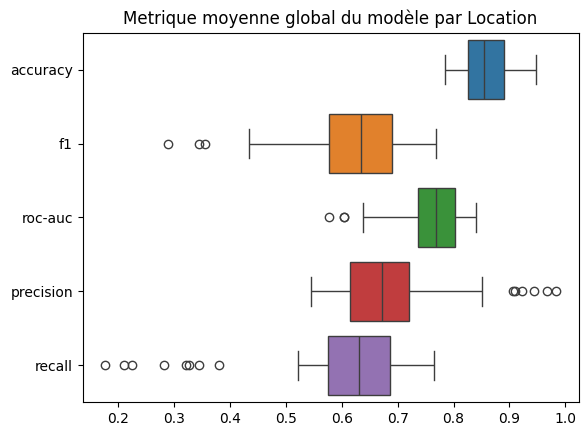

In [30]:
sns.boxplot(data = df_global[['accuracy', 'f1', 'roc-auc', 'precision', 'recall']], orient = 'h')
plt.title('Metrique moyenne global du modèle par Location')
plt.show()

In [31]:
df_global.columns

Index(['accuracy', 'f1', 'roc-auc', 'precision', 'recall', 'precision_0',
       'recall_0', 'f1_0', 'support_0', 'precision_1', 'recall_1', 'f1_1',
       'support_1', 'macro_avg_precision', 'macro_avg_recall', 'macro_avg_f1',
       'weighted_avg_precision', 'weighted_avg_recall', 'weighted_avg_f1'],
      dtype='object')

In [33]:
classif

{'0.0': {'precision': 0.960431654676259,
  'recall': 0.9638989169675091,
  'f1-score': 0.9621621621621622,
  'support': 277.0},
 '1.0': {'precision': 0.5454545454545454,
  'recall': 0.5217391304347826,
  'f1-score': 0.5333333333333333,
  'support': 23.0},
 'accuracy': 0.93,
 'macro avg': {'precision': 0.7529431000654022,
  'recall': 0.7428190237011458,
  'f1-score': 0.7477477477477478,
  'support': 300.0},
 'weighted avg': {'precision': 0.928616742969261,
  'recall': 0.93,
  'f1-score': 0.9292852852852853,
  'support': 300.0}}

In [ ]:
print(df_global['precision_0'].mean())
print(df_global['recall_0'].mean())
print(df_global['f1_0'].mean())
print(df_global['support_0'].mean())

print(df_global['precision_1'].mean())
print(df_global['recall_1'].mean())
print(df_global['f1_1'].mean())
print(df_global['support_1'].mean())

print(df_global['accuracy'].mean())

print(df_global['macro_avg_precision'].mean())
print(df_global['macro_avg_recall'].mean())
print(df_global['macro_avg_f1'].mean())

print(df_global['weighted_avg_precision'].mean())
print(df_global['weighted_avg_recall'].mean())
print(df_global['weighted_avg_f1'].mean())


In [ ]:
df = pd.read_csv('../data/coffsharbour/climate/coffsharbour.csv')


columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

print('colonne du dataframe', df.columns)
print('colonne drop', columns_to_drop)


transformers = []

if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))

if 'Evaporation' not in columns_to_drop:
    transformers.append(('evaporation_transformer', evaporation_transformer()))
if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))

if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

for cloud_col in ['Cloud9am', 'Cloud3pm']:
    if cloud_col not in columns_to_drop:
        transformers.append((f'{cloud_col.lower()}_transformer', cloud_transformer(col_select=cloud_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')

print('avant', df.shape)
df.dropna(inplace = True)
print('apres', df.shape)

X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poids = y_train.value_counts(normalize = True)


model = LogisticRegression(verbose = 1,
                           C = 1,
                           max_iter = 1000,
                           penalty = 'l1',
                           solver = 'liblinear',
                           intercept_scaling = 0.1,
                           tol = 0.01
                        )


model.fit(X_train_scaled, y_train)


prob = model.predict_proba(X_test_scaled)

y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

# if y_train.value_counts(normalize = True)[1] < 0.15:
#         threshold = 0.165
# if y_train.value_counts(normalize = True)[1] > 0.30:
#     threshold = 0.85
# else:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
diff = abs(precision - recall)
threshold = thresholds[diff.argmin()]

print('threshold :', threshold)

y_pred = (y_pred_prob1 > threshold).astype(int)


print('Accuracy score: ', model.score(X_test_scaled, y_test))
print('F1 score: ', f1_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))
print('Brier score: ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
classif = classification_report(y_test, y_pred)
print(classif)

In [ ]:
bb

In [10]:
df1 = pd.read_csv('../data/coffsharbour/climate/coffsharbour.csv')
df2 = pd.read_csv('../data/weatherAUS.csv')
df2 = df2[df2['Location'] == 'CoffsHarbour']

df_glob = pd.concat([df1, df2]).drop(columns = 'Unnamed: 0')

df_glob.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,Temp9am,Humidity9am,...,Pressure9am,Temp3pm,Humidity3pm,Cloud3pm,WindDir3pm,WindSpeed3pm,Pressure3pm,Location,RainToday,RainTomorrow
0,2024-01-1,18.9,27.0,199.0,NaN,NaN,ENE,28.0,21.6,91.0,...,1022.5,26.2,69.0,8.0,ENE,17.0,1020.9,CoffsHarbour,Yes,Yes
1,2024-01-2,19.7,27.5,4.8,NaN,NaN,E,26.0,23.6,87.0,...,1020.2,26.8,65.0,NaN,E,17.0,1018.5,CoffsHarbour,Yes,No
2,2024-01-3,18.3,27.5,0.1,NaN,NaN,SW,30.0,23.9,71.0,...,1017.9,26.0,71.0,8.0,S,15.0,1016.0,CoffsHarbour,No,No
3,2024-01-4,20.8,28.1,0.8,NaN,NaN,S,31.0,26.3,74.0,...,1015.1,27.1,75.0,NaN,SE,13.0,1013.3,CoffsHarbour,No,No
4,2024-01-5,22.8,28.1,NaN,NaN,NaN,SSW,52.0,25.2,70.0,...,1017.9,26.7,72.0,8.0,SSW,28.0,1017.4,CoffsHarbour,No,Yes


In [11]:
df_glob.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,Temp9am,Humidity9am,Cloud9am,WindSpeed9am,Pressure9am,Temp3pm,Humidity3pm,Cloud3pm,WindSpeed3pm,Pressure3pm
count,3405.000000,3400.000000,3354.000000,1785.000000,1494.000000,3056.000000,3405.000000,3401.000000,2421.000000,3124.000000,3109.000000,3406.000000,3398.000000,2455.000000,3125.000000,3108.000000
mean,14.603671,24.111882,5.136255,3.905154,7.358367,39.148233,20.327195,68.393120,4.508881,15.173496,1018.205532,22.480769,62.779282,4.672912,21.120320,1015.844208
std,5.166262,3.872186,17.390084,2.021251,3.747901,12.313444,4.014717,14.711794,2.958323,7.678831,6.119154,3.638703,14.479310,2.844542,8.897459,6.136991
min,0.600000,12.900000,0.000000,0.000000,0.000000,15.000000,8.600000,21.000000,0.000000,0.000000,998.300000,11.700000,11.000000,0.000000,0.000000,993.700000
25%,10.800000,21.000000,0.000000,2.400000,4.600000,30.000000,17.200000,59.000000,1.000000,9.000000,1014.000000,19.700000,54.000000,2.000000,15.000000,1011.800000
50%,15.400000,24.200000,0.000000,3.600000,8.500000,37.000000,20.600000,68.000000,5.000000,15.000000,1018.200000,22.500000,63.000000,5.000000,19.000000,1015.900000
75%,18.700000,27.000000,2.000000,5.200000,10.200000,48.000000,23.400000,79.000000,7.000000,20.000000,1022.400000,25.500000,71.000000,7.000000,28.000000,1020.000000
max,26.300000,39.200000,371.000000,19.800000,13.800000,113.000000,33.200000,98.000000,8.000000,56.000000,1036.800000,37.400000,99.000000,8.000000,61.000000,1035.000000


In [12]:
print(df1.shape)
print(df2.shape)
print(df_glob.shape)

(411, 24)
(3009, 23)
(3420, 23)


In [21]:
df1 = pd.read_csv('../data/coffsharbour/climate/coffsharbour.csv')
df2 = pd.read_csv('../data/weatherAUS.csv')
df2 = df2[df2['Location'] == 'CoffsHarbour']

df_glob = pd.concat([df1, df2]).drop(columns = 'Unnamed: 0')

df_glob.head()


df = df_glob.copy()


columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

print('colonne du dataframe', df.columns)
print('colonne drop', columns_to_drop)


transformers = []

if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))

if 'Evaporation' not in columns_to_drop:
    transformers.append(('evaporation_transformer', evaporation_transformer()))
if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))

if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

for cloud_col in ['Cloud9am', 'Cloud3pm']:
    if cloud_col not in columns_to_drop:
        transformers.append((f'{cloud_col.lower()}_transformer', cloud_transformer(col_select=cloud_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')

print('avant', df.shape)
df.dropna(inplace = True)
print('apres', df.shape)

X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poids = y_train.value_counts(normalize = True)

print(poids)

model = LogisticRegression(verbose = 1,
                           C = 1,
                           max_iter = 1000,
                           penalty = 'l1',
                           solver = 'liblinear',
                           intercept_scaling = 0.1,
                           tol = 0.01
                        )


model.fit(X_train_scaled, y_train)


prob = model.predict_proba(X_test_scaled)

y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

if y_train.value_counts(normalize = True)[1] < 0.15:
        threshold = 0.165
if y_train.value_counts(normalize = True)[1] > 0.30:
    threshold = 0.85
else:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
    diff = abs(precision - recall)
    threshold = thresholds[diff.argmin()]

print('threshold :', threshold)

y_pred = (y_pred_prob1 > threshold).astype(int)


print('Accuracy score: ', model.score(X_test_scaled, y_test))
print('F1 score: ', f1_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))
print('Brier score: ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
classif = classification_report(y_test, y_pred)
print(classif)

colonne du dataframe Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'Temp9am', 'Humidity9am', 'Cloud9am',
       'WindDir9am', 'WindSpeed9am', 'Pressure9am', 'Temp3pm', 'Humidity3pm',
       'Cloud3pm', 'WindDir3pm', 'WindSpeed3pm', 'Pressure3pm', 'Location',
       'RainToday', 'RainTomorrow'],
      dtype='object')
colonne drop ['Evaporation', 'Sunshine']
Pas de station à moins de 50 km de CoffsHarbour
avant (3363, 116)
apres (2193, 116)
RainTomorrow
0.0    0.650852
1.0    0.349148
Name: proportion, dtype: float64
[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 5
iter   5  #CD cycles 1
iter   6  #CD cycles 14
optimization finished, #iter = 6
Objective value = 665.391551
#nonzeros/#features = 70/116
threshold : 0.85
Accuracy score:  0.8214936247723132
F1 score:  0.3884297520661157
ROC AUC score:  0.6181941526610645
Brier score:  0.26958105646630237 


[[354   3]
 [1